In this notebook we'll get a naive limit based on the intensity of the isotropic component, by requiring _Fermi_ data not overproduce the measured (= fit) IGRB.

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/group/hepheno/smsharma/Fermi-LSS/2MASS/")
import particle as pa
from units import *
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from tqdm import *

%matplotlib inline

In [140]:
# Set plotting options

import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['figure.figsize'] = (8,8/1.61803398875)
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['text.usetex'] = True

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['ytick.major.pad'] = 8

mpl.rcParams['axes.labelpad'] = 9

Load and plot spectrum.

In [131]:
spec_ary = np.load("../AdditionalData/norms/P8UCVA_spec_new.npy")

In [132]:
en = [sp[0] for sp in spec_ary]
bubs_ary = np.transpose([sp[1]['bubs-0'] for sp in spec_ary])
p7_ary = np.transpose([sp[1]['p7-0'] for sp in spec_ary])
ps_model_ary = np.transpose([sp[1]['ps_model-0'] for sp in spec_ary])
iso_ary = np.transpose([sp[1]['iso-0'] for sp in spec_ary])

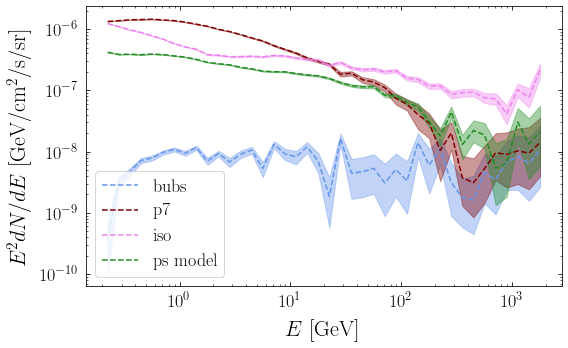

In [141]:
plt.fill_between(en, bubs_ary[0], bubs_ary[2], color = 'cornflowerblue', alpha = 0.4)
plt.plot(en, bubs_ary[1], color = 'cornflowerblue', ls = '--', label="bubs")
plt.fill_between(en, p7_ary[0], p7_ary[2], color = 'maroon', alpha = 0.4)
plt.plot(en, p7_ary[1], color = 'maroon', ls = '--', label="p7")
plt.fill_between(en, iso_ary[0], iso_ary[2], color = 'violet', alpha = 0.4)
plt.plot(en, iso_ary[1], color = 'violet', ls = '--', label="iso")
plt.fill_between(en, ps_model_ary[0], ps_model_ary[2], color = 'forestgreen', alpha = 0.4)
plt.plot(en, ps_model_ary[1], color = 'forestgreen', ls = '--', label="ps model")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$E$ [GeV]")
plt.ylabel("$E^2 dN/dE$ [GeV/cm$^2$/s/sr]")
plt.legend(fancybox=True, loc = "lower left")
plt.tight_layout()
# plt.savefig("P8UCVA_spec_new.pdf")

In [134]:
en_bins = 2*np.logspace(-1,3,41)
bin_widths = [en_bins[i+1]-en_bins[i] for i in range(len(en_bins)-1)]
bin_centers = [10**((np.log10(en_bins[i+1])+np.log10(en_bins[i]))/2) for i in range(len(en_bins)-1)]

In [135]:
jfactor_sum = np.sum(np.load("../GenerateJFactors/GenMapsCentered/Jfactor_DS_true_map_200.0_200.0_200.0b2e+20_a2e+12.npy"))

In [49]:
IGRB_df = pd.read_csv("IGRB.dat", skiprows=61, delim_whitespace=True,header=None)
IGRB_df = IGRB_df[IGRB_df[0] == 'A']
f_bin_widths = (IGRB_df[2] - IGRB_df[1])/1000
f_bin_centers = np.array((10**((np.log10(IGRB_df[1]) + np.log10(IGRB_df[2]))/2))/1000)

In [86]:
sigma_igrb = np.array((IGRB_df[4] + IGRB_df[5])/2)
sigma_igrb_interp = InterpolatedUnivariateSpline(f_bin_centers, f_bin_centers*2*sigma_igrb/f_bin_widths)

In [120]:
mchi_ary = []
lim_ary = []
for mchi in [10,100,1000,10000]:
# for mchi in tqdm(np.logspace(1,4,20)):
    particle = pa.Particle(channel='b', m_chi = mchi * GeV)
    LL=0
    found = False
    for sigma_v in np.logspace(-26,-16):
        if found: continue
        phi_dm_ary = []
        for i in range(len(en_bins)-1):
            if en_bins[i+1] < mchi:
                phi_i = iso_ary[1][i]
                phi_dm = (bin_centers[i]*GeV)**2*jfactor_sum*particle.Phi(mchi*GeV,sigma_v*Centimeter**3*Sec**-1,en_bins[i]*GeV, en_bins[i+1]*GeV)/(GeV*Centimeter**-2*Sec**-1)/(bin_widths[i]*GeV)/(4*np.pi)
                phi_dm_ary.append(phi_dm)
                if phi_dm > phi_i:
                    LL += -0.5*(phi_i - phi_dm)**2/(iso_ary[2]-iso_ary[1])[i]**2#sigma_igrb_interp(bin_centers[i])**2
            else:
                phi_dm_ary.append(0)
        if LL < -2.71:
            print mchi, sigma_v
            mchi_ary.append(mchi)
            lim_ary.append(sigma_v)
            found = True

The cross section assumed is 3e-26
10 1.84206996933e-23
The cross section assumed is 3e-26
100 1.20679264064e-22
The cross section assumed is 3e-26
1000 1.26485521686e-21
The cross section assumed is 3e-26
10000 5.17947467923e-21


In [114]:
np.save("igrb_lim.npy", lim_ary)
np.save("igrb_mchi.npy", mchi_ary)

In [137]:
mchi = 100
particle = pa.Particle(channel='b', m_chi = mchi * GeV)
sigma_v = 3e-26
phi_dm_ary = []
for i in range(len(en_bins)-1):
    if en_bins[i+1] < mchi:
        phi_i = iso_ary[1][i]
        phi_dm = (bin_centers[i]*GeV)**2*jfactor_sum*particle.Phi(mchi*GeV,sigma_v*Centimeter**3*Sec**-1,en_bins[i]*GeV, en_bins[i+1]*GeV)/(GeV*Centimeter**-2*Sec**-1)/(bin_widths[i]*GeV)
        phi_dm_ary.append(phi_dm)
    else:
        phi_dm_ary.append(0)

The cross section assumed is 3e-26


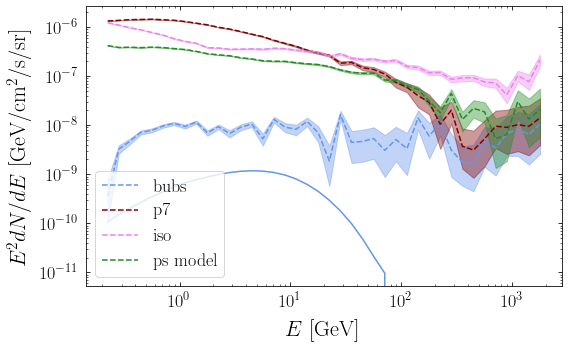

In [142]:
plt.fill_between(en, bubs_ary[0], bubs_ary[2], color = 'cornflowerblue', alpha = 0.4)
plt.plot(en, bubs_ary[1], color = 'cornflowerblue', ls = '--', label="bubs")
plt.fill_between(en, p7_ary[0], p7_ary[2], color = 'maroon', alpha = 0.4)
plt.plot(en, p7_ary[1], color = 'maroon', ls = '--', label="p7")
plt.fill_between(en, iso_ary[0], iso_ary[2], color = 'violet', alpha = 0.4)
plt.plot(en, iso_ary[1], color = 'violet', ls = '--', label="iso")
plt.fill_between(en, ps_model_ary[0], ps_model_ary[2], color = 'forestgreen', alpha = 0.4)
plt.plot(en, ps_model_ary[1], color = 'forestgreen', ls = '--', label="ps model")
plt.plot(bin_centers, np.array(phi_dm_ary))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$E$ [GeV]")
plt.ylabel("$E^2 dN/dE$ [GeV/cm$^2$/s/sr]")
plt.legend(fancybox=True, loc = "lower left")
plt.tight_layout()
# plt.savefig("P8UCVA_spec_new.pdf")